Se procede a realizar la carga de librerías a utilizar

In [81]:
import pandas as pd
import numpy as np
import webbrowser as wb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns 

from dateutil.parser import parse
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

# 1. Análisis preliminar

Se procede a realizar la carga del dataset de test para House pricing.

In [82]:
dataset = pd.read_csv("train.csv", sep = ",")

Se utilizará la función **ProfileReport** para obtener un reporte con análisis preliminar exhaustivo del dataset.

In [3]:
profile = ProfileReport(dataset, title = "Reporte preliminar")
#profile.to_notebook_iframe() # Se procede a excluir la visualización en el archivo debido a errores en visualización. En su lugar se procede con la exportación a un archivo HTML.
profile.to_file("reporte.html")
wb.open_new_tab('reporte.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

True

# 2. Análisis de modelo

Se realiza la separación del dataset entre train y test

In [83]:
data_train = dataset.sample(frac=0.8, random_state=2023) 
data_test = dataset.drop(data_train.index) 
data_train.shape, data_test.shape

((1168, 81), (292, 81))

## 2.1 Configuración y selección de modelos

Se realiza la configuración del modelo

In [84]:
df = setup(data=data_train,
                target = 'SalePrice', # Variable objetivo
                session_id = 2023, # Asegurando la reproducibilidad
                numeric_imputation= 'knn', # Imputación numérica utilizando el acercamiento del KNN (K-Nearest Neighbor)
                max_encoding_ohe = 3, # Imputación categórica por One Hot Encoding
                categorical_imputation = 'mode', # Imputación categórica por Frecuency Encoding       
                transformation = True, # Se realiza la transformación de datos         
                outliers_threshold = 0.05, # Intervalo de parámetros que se descartarán para los outliers
                normalize = True, # Se acepta la normalización
                normalize_method = 'minmax', # Selección del métrodo de normalización,
                n_jobs = None, # Para poder realizar trabajos en paralelo
                log_experiment = True, # Guardar el log del experimento via mlflow.
                experiment_name = 'SalePrice_house') # Nombre del experimento

,Description,Value
0,Session id,2023
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1168, 81)"
4,Transformed data shape,"(1168, 87)"
5,Transformed train set shape,"(817, 87)"
6,Transformed test set shape,"(351, 87)"
7,Ordinal features,6
8,Numeric features,37
9,Categorical features,43


Se seleccionan los tres mejores modelos para el análisis basados en los resultados del RMSE. Se excluyen del cálculo la regresión lineal (*lr*) y Least Angle Regression (*lar*) debido a que sus resultados ___________________ .

In [85]:
best = compare_models(sort='RMSE', exclude=['lar', 'lr'], n_select=3) 

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:29:05
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Lasso Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,17280.3918,756015101.2977,26263.8898,0.8681,0.1397,0.1017,1.2320
lightgbm,Light Gradient Boosting Machine,17506.7110,836261965.7587,27928.6580,0.8544,0.1430,0.1014,0.9610
et,Extra Trees Regressor,18325.2437,849421054.8134,28118.3078,0.8567,0.1468,0.1067,1.5800
rf,Random Forest Regressor,17984.9218,861646526.8375,28143.1361,0.8494,0.1486,0.1070,2.2660
ada,AdaBoost Regressor,23028.6276,1190813511.3989,33690.9076,0.7939,0.1892,0.1474,0.9440
huber,Huber Regressor,21382.3086,1284243932.0694,35001.7817,0.7822,0.1601,0.1178,0.9090
br,Bayesian Ridge,23035.3078,1330416422.0882,35470.2268,0.7689,0.1977,0.1365,0.8250
ridge,Ridge Regression,23129.0170,1347606067.8172,35649.4398,0.7652,0.2085,0.1379,0.7430
par,Passive Aggressive Regressor,23740.4706,1536816705.4081,38708.4949,0.7424,0.1702,0.1263,1.0630
lasso,Lasso Regression,24029.8420,1633920612.5883,38786.6141,0.7093,0.2318,0.1453,0.7550


Se extraen los datos de la comparación de modelos

In [86]:
modelos = pull()

Se visualizan cuales son los modelos elegidos y sus parámetros

In [45]:
print(best)

[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='squared_error',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=100, n_iter_no_change=None,
                          random_state=2023, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=None, num_leaves=31, objective=None,
              random_state=2023, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
          

## 2.2 Visualización de modelos

Se analiza de manera individual los modelos elegidos para poder realizar el entrenamiento de cada modelo

### 2.2.1 Modelo Gradient Boosting Regressor - *GBR*

Se procede a la creación del modelo GBR

In [48]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,23605.5966,2345305516.2718,48428.3545,0.5385,0.2256,0.1524
1,15979.6412,577945060.6841,24040.4879,0.9254,0.1155,0.0874
2,18973.7058,1014087264.4503,31844.7368,0.8840,0.1217,0.0924
3,17240.2910,563449951.0299,23737.1007,0.8968,0.1455,0.1001
4,18466.1943,673688123.8643,25955.5028,0.8686,0.1324,0.0991
5,14729.7852,351311609.0062,18743.3084,0.9241,0.1471,0.1061
6,16338.8134,491932763.4293,22179.5573,0.9135,0.1270,0.0981
7,15676.5257,521924660.3447,22845.6705,0.9085,0.1310,0.0984
8,14832.4559,391093306.6132,19776.0792,0.9309,0.1145,0.0859


Se seleccionan hiperparámetros para poder analizarlos

In [49]:
params = {
    'n_estimators': [10,100],
    'learning_rate': [0.01, 0.1],
    'alpha':[0.8,0.9]
}
tuned_gbr_model = tune_model(
    estimator = gbr,
    optimize = 'RMSE',
    fold = 10,
    n_iter = 100,
    custom_grid = params
)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:34:57
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,23605.5966,2345305516.2718,48428.3545,0.5385,0.2256,0.1524
1,15979.6412,577945060.6841,24040.4879,0.9254,0.1155,0.0874
2,18973.7058,1014087264.4503,31844.7368,0.8840,0.1217,0.0924
3,17240.2910,563449951.0299,23737.1007,0.8968,0.1455,0.1001
4,18466.1943,673688123.8643,25955.5028,0.8686,0.1324,0.0991
5,14729.7852,351311609.0062,18743.3084,0.9241,0.1471,0.1061
6,16338.8134,491932763.4293,22179.5573,0.9135,0.1270,0.0981
7,15676.5257,521924660.3447,22845.6705,0.9085,0.1310,0.0984
8,14832.4559,391093306.6132,19776.0792,0.9309,0.1145,0.0859


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Se visualizan las características importantes del modelo

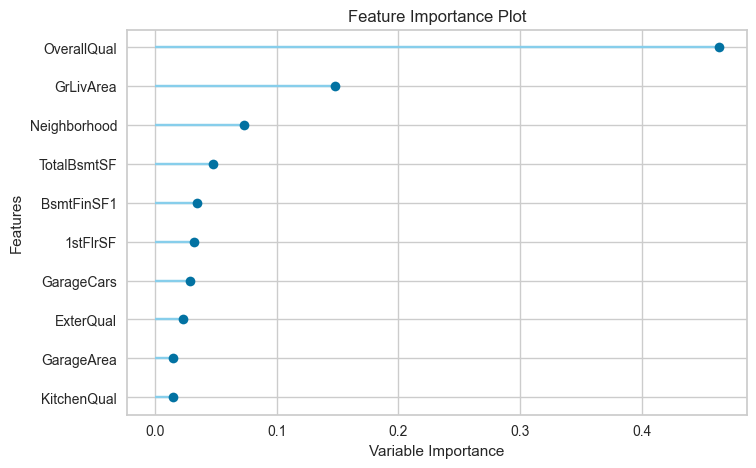

In [53]:
plot_model(gbr, plot='feature')

### 2.2.2 Modelo Light Gradient Boosting Machine - *lightgbm*

Se procede a la creación del modelo

In [51]:
lightgbm = create_model('lightgbm')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:40:34
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22995.4623,2323967115.5401,48207.5421,0.5427,0.2250,0.1479
1,16192.7498,752432340.1148,27430.5002,0.9029,0.1115,0.0845
2,19200.3789,1124837004.6183,33538.5898,0.8713,0.1282,0.0980
3,18408.8890,754508141.1261,27468.3116,0.8618,0.1495,0.0987
4,18465.5194,661344476.5216,25716.6187,0.8710,0.1291,0.0965
5,16774.3432,581794456.8971,24120.4158,0.8743,0.1587,0.1133
6,16591.5988,629453611.4507,25088.9141,0.8893,0.1306,0.0939
7,14275.4273,438218584.8455,20933.6711,0.9232,0.1361,0.0952
8,16451.2410,503831110.4771,22446.1825,0.9110,0.1293,0.0942


Se seleccionan hiperparámetros para poder analizarlos

In [71]:
params = {
    'n_estimators': [10,100],
    'learning_rate': [0.01, 0.1],
    'alpha':[0.8,0.9],
    'max_depth':[1,10]
}
tuned_gbr_model = tune_model(
    estimator = lightgbm,
    optimize = 'RMSE',
    fold = 10,
    n_iter = 10,
    custom_grid = params
)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,23204.2781,2331624679.4123,48286.8997,0.5412,0.2252,0.1490
1,15704.5847,709079536.9639,26628.5474,0.9085,0.1087,0.0812
2,19073.0127,1128123442.3089,33587.5489,0.8709,0.1274,0.0981
3,18793.3352,778911225.7327,27908.9811,0.8573,0.1542,0.1022
4,18017.0921,647993375.4645,25455.7140,0.8736,0.1263,0.0931
5,16700.0828,601194388.4567,24519.2657,0.8701,0.1607,0.1132
6,16420.9213,632376847.0833,25147.1041,0.8887,0.1315,0.0931
7,14562.1511,428464623.1982,20699.3870,0.9249,0.1381,0.0983
8,16390.6069,510668843.2190,22597.9832,0.9098,0.1284,0.0929


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2877
[LightGBM] [Info] Number of data points in the train set: 735, number of used features: 73
[LightGBM] [Info] Start training from score 182932.587755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2861
[LightGBM] [Info] Number of data points in the train set: 735, number of used features: 72
[LightGBM] [Info] Start training from score 182206.167347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2857
[LightGBM] [Info] Number of data points in the trai

Se visualizan las características importantes del modelo

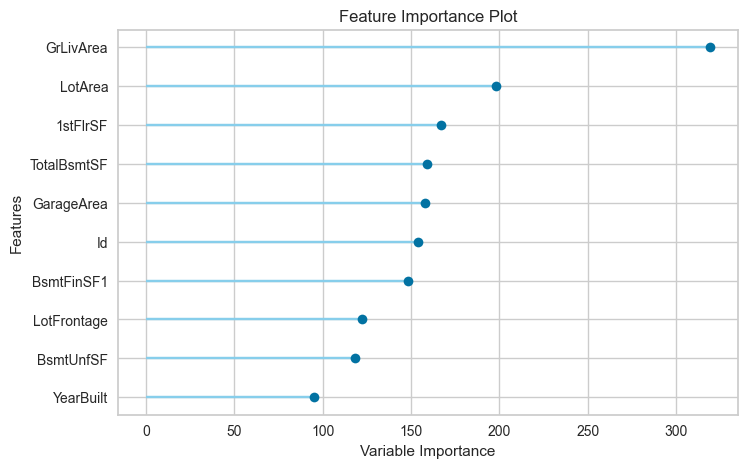

In [54]:
plot_model(lightgbm, plot='feature')

### 2.2.3 Modelo Extra Trees Regressor *et*

Se procede a la creación del modelo et

In [56]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,23900.2867,1886149120.7359,43429.8183,0.6288,0.2225,0.1507
1,15888.1376,573543449.3345,23948.7672,0.9260,0.1146,0.0870
2,24045.5902,1778508916.3421,42172.3715,0.7965,0.1503,0.1115
3,18211.3713,788775566.7690,28085.1485,0.8555,0.1466,0.1032
4,18669.6151,723272739.7915,26893.7305,0.8589,0.1300,0.0968
5,15836.4602,441666916.3909,21015.8730,0.9045,0.1531,0.1132
6,16860.6917,576599470.4212,24012.4857,0.8986,0.1408,0.1042
7,15985.3515,547628577.5554,23401.4653,0.9040,0.1468,0.1051
8,16264.6853,455580404.5813,21344.3296,0.9195,0.1262,0.0970


Se seleccionan hiperparámetros para poder analizarlos

In [64]:
params = {
    'n_estimators': [10,100],
    'ccp_alpha':[0.01,0.1]
}
tuned_gbr_model = tune_model(
    estimator = et,
    optimize = 'RMSE',
    fold = 20,
    n_iter = 100,
    custom_grid = params
)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:00:51
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,21034.6366,1060393115.4530,32563.6779,0.7727,0.1839,0.1308
1,26993.8334,2722994046.0332,52182.3155,0.5038,0.2564,0.1754
2,14705.6102,528945167.4598,22998.8080,0.9324,0.1045,0.0813
3,17566.9893,629650622.4780,25092.8401,0.9180,0.1202,0.0936
4,17680.4441,566505051.5830,23801.3666,0.8778,0.1338,0.1029
5,28342.4115,2573661302.4726,50731.2655,0.7970,0.1538,0.1166
6,20837.9724,885933769.3119,29764.6396,0.8736,0.1343,0.1085
7,15916.2207,518003162.4314,22759.6828,0.8662,0.1448,0.0997
8,16332.1215,486222840.1060,22050.4612,0.9188,0.1181,0.0906


Fitting 20 folds for each of 4 candidates, totalling 80 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


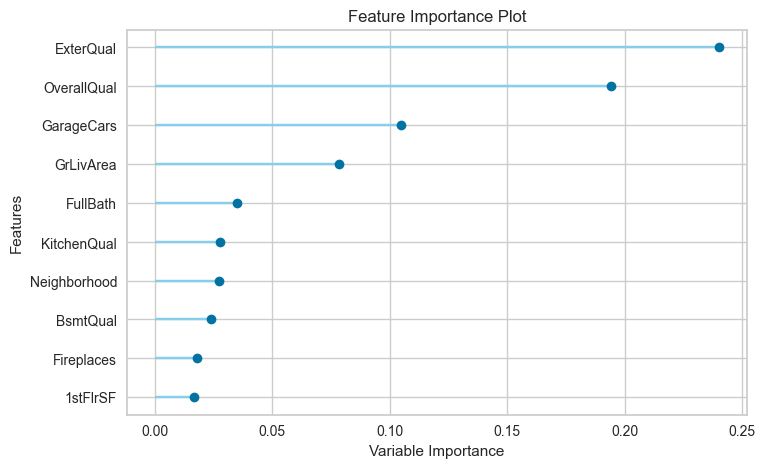

In [65]:
plot_model(et, plot='feature')

# 3. Análisis de los modelos

In [111]:
modelos2=modelos.copy()

In [112]:
modelos2['modelos']=modelos2.index

In [113]:
modelos2.reset_index(drop=True, inplace=True)

In [120]:
print(modelos2.loc[1,['Model']])

Model    Light Gradient Boosting Machine
Name: 1, dtype: object


In [131]:
print(modelos2.loc[1, 'Model'])

Light Gradient Boosting Machine


In [134]:
len(best)

3

In [138]:
for i in range(0,len(best)):
    print(modelos2.at[i, 'Model'])

Gradient Boosting Regressor
Light Gradient Boosting Machine
Extra Trees Regressor


In [141]:
for model in best:
    for i in range(0,len(best)):
        print(modelos2.at[i, 'Model'])
        evaluate_model(model)
        print('')


Gradient Boosting Regressor


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Light Gradient Boosting Machine


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Extra Trees Regressor


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Gradient Boosting Regressor


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Light Gradient Boosting Machine


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Extra Trees Regressor


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Gradient Boosting Regressor


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Light Gradient Boosting Machine


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Extra Trees Regressor


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…